# **Packages**

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# **Model**

In [8]:
class RNNModel(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(1, hidden_dim, batch_first=True)        
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output_rnn, hidden_rnn = self.rnn(x)
        last_hidden = hidden_rnn[-1,:,:]
        output = self.fc(last_hidden)
        return output

# **Utils**

In [9]:
def create_sequences(data, lag, ahead):
    """
    Create sequences from time series data for use in time series forecasting.

    Parameters:
    - data (array-like): The time series data as a list or numpy array.
    - lag (int): The number of data points in each input sequence.
    - ahead (int): The number of data points to predict in the future.

    Returns:
    - X (numpy.ndarray): A 2D array of shape (num_sequences, lag) containing the input sequences.
    - y (numpy.ndarray): A 2D array of shape (num_sequences, ahead) containing the corresponding labels.
    """
    X, y = [], []
    for i in range(len(data) - lag - ahead + 1):
        X.append(data[i:(i + lag)])
        y.append(data[(i + lag):(i + lag + ahead)])
    return np.array(X), np.array(y)

def prepare_data(data, lag, ahead, train_ratio, batch_size):
    """
    Prepare the data for the Conv1D model training.

    Parameters:
    - data: The raw time series data.
    - lag: The number of time steps to use for predictions.
    - ahead: The number of time steps ahead to predict.
    - train_ratio: The ratio of the dataset to include in the train split.
    - batch_size: The size of the batch for the DataLoader.

    Returns:
    - train_loader: DataLoader for the training set.
    - X_test_tensor: PyTorch tensor for the test features.
    - y_test_tensor: PyTorch tensor for the test labels.
    """
    # Create sequences
    X, y = create_sequences(data, lag, ahead)

    # Flatten all the features of a sample for MLP 
    X = X.reshape(X.shape[0], -1, 1)

    # Split the data
    train_size = int(len(X) * train_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # DataLoader
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    return train_loader, X_test_tensor, y_test_tensor

def train_model(model, criterion, optimizer, train_loader, num_epochs):
    """
    Train the MLP model.

    Parameters:
    - model: The PyTorch model to train.
    - criterion: The loss function.
    - optimizer: The optimization algorithm.
    - train_loader: DataLoader for the training set.
    - num_epochs: The number of epochs to train for.

    Returns:
    - model: The trained model.
    - losses: A list of loss values per epoch.
    """
    losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (sequences, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return model, losses

def evaluate_model(model, X_test_tensor, y_test_tensor, ahead):
    """
    Evaluate the MLP model.

    Parameters:
    - model: The PyTorch model to evaluate.
    - X_test_tensor: PyTorch tensor for the test features.
    - y_test_tensor: PyTorch tensor for the test labels.
    - ahead: The number of time steps ahead that the model predicts.

    Returns:
    - r2: R-squared score.
    - mae: Mean Absolute Error.
    - mse: Mean Squared Error.
    """
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        predictions = predictions.view(-1, ahead).numpy()  # Reshape predictions to match y_test
        y_test = y_test_tensor.numpy()
        print(f'{predictions.shape = }')
        print(f'{y_test.shape = }')

        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)

    print(f'R2 Score: {r2}')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')

    return r2, mae, mse

def plot_losses(losses):
    """
    Plot the training losses.

    Parameters:
    - losses: A list of loss values per epoch.
    """
    plt.plot(losses, label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# **Data**

In [10]:
df = pd.read_csv('temp.csv')
data = df['Temperature (C)'].values

# **Config**

In [11]:
num_epochs = 20
train_ratio = 0.8
batch_size = 64
lr = 0.001

In [12]:
lag = 64 
ahead = 1
hidden_dim = 32

# **Train**

In [13]:
train_loader, X_test_tensor, y_test_tensor = prepare_data(data, lag, ahead, train_ratio, batch_size)
model = RNNModel(hidden_dim=hidden_dim, output_dim=ahead)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model, losses = train_model(model, criterion, optimizer, train_loader, num_epochs)

Epoch [1/20], Loss: 47.6872
Epoch [2/20], Loss: 4.5143
Epoch [3/20], Loss: 2.5410
Epoch [4/20], Loss: 2.1953
Epoch [5/20], Loss: 2.0860
Epoch [6/20], Loss: 2.0533
Epoch [7/20], Loss: 2.0093
Epoch [8/20], Loss: 1.9670
Epoch [9/20], Loss: 1.9360
Epoch [10/20], Loss: 1.9043
Epoch [11/20], Loss: 1.8555
Epoch [12/20], Loss: 1.8284
Epoch [13/20], Loss: 1.8232
Epoch [14/20], Loss: 1.7815
Epoch [15/20], Loss: 1.9371
Epoch [16/20], Loss: 1.8309
Epoch [17/20], Loss: 2.0560
Epoch [18/20], Loss: 1.8822
Epoch [19/20], Loss: 1.7475
Epoch [20/20], Loss: 1.7438


# **Evaluate**

In [14]:
r2, mae, mse = evaluate_model(model, X_test_tensor, y_test_tensor, ahead)

predictions.shape = (19278, 1)
y_test.shape = (19278, 1)
R2 Score: 0.9854880571365356
MAE: 0.7088725566864014
MSE: 1.170409083366394


# **Plot**

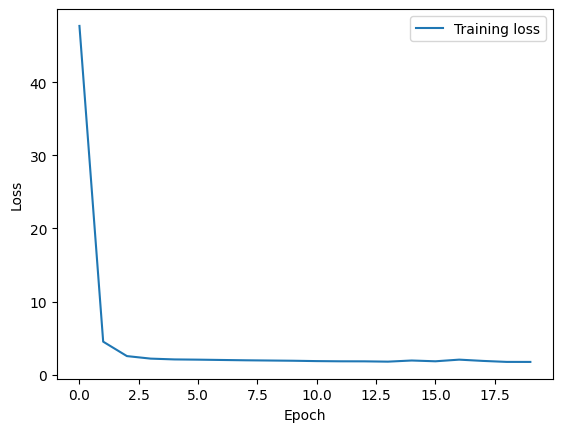

In [15]:
plot_losses(losses)

In [16]:
predictions = model(X_test_tensor).detach().numpy()
y_test = y_test_tensor.numpy()

print(predictions.shape)
print(y_test.shape)

(19278, 1)
(19278, 1)


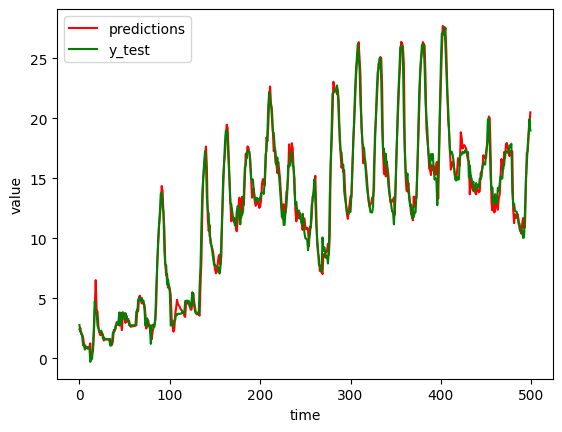

In [17]:
plt.plot(predictions[:500,0], 'r', label='predictions')
plt.plot(y_test[:500,0], 'g', label='y_test')

plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()